# Battery_SoC_MLP_with"Time"

In [1]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

C:\Users\Marven\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load and clean the datasets

In [2]:
data_file = "./TripB14.csv"

In [3]:
data = pd.read_csv(data_file, encoding="ISO-8859-1", sep=";")

In [4]:
def get_soc_using_coulomb_counting_method(df, battery_voltage, battery_usable_capacity_kWh):
    
    estimated_soc = []
    
    SOC_0 = df["SoC [%]"][0]  # Initial State of Charge in %
    
    # Convert capacity to Ampere-seconds (As) using battery voltage
    Q_rated = (battery_usable_capacity_kWh * 1000) / battery_voltage * 3600   # Convert kWh to As
    
    # Time difference between samples
    time_difference = df['Time [s]'].diff().fillna(0)  # First diff is NaN, set to 0
    
    # Coulomb Counting Method to estimate SOC
    estimated_soc = SOC_0 + (df['Battery Current [A]'] * time_difference).cumsum() / Q_rated * 100
    
    return estimated_soc

In [5]:
# Estimate SoC using Coulomb counting method on all dataframes

data["Estimated SoC (Coulomb counting method)"] = get_soc_using_coulomb_counting_method(df=data, battery_voltage=360, battery_usable_capacity_kWh=18.8)

In [6]:
# Difference between SoC and Estimated SoC

data["Delta"] = data["SoC [%]"] - data["Estimated SoC (Coulomb counting method)"]

In [7]:
key_features = ["Time [s]", "Velocity [km/h]", "Battery Voltage [V]", "Battery Current [A]", "Battery Temperature [°C]"]

In [8]:
# Extract features and target variable
X = data[key_features]  # Features 
y = data["Delta"]   # Target (Difference between SoC and Estimated SoC)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.33, shuffle=False)

## Convert Data to PyTorch form

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_validation_tensor = torch.tensor(X_validation_scaled, dtype=torch.float32)
y_validation_tensor = torch.tensor(y_validation.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [10]:
# Create the Data loader
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Define the MLP model

In [11]:
class MLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation=nn.ReLU):
        
        super(MLP, self).__init__()
        layers = [nn.Linear(input_dim, hidden_dim), activation()]
        
        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation())
            layers.append(nn.Dropout(0.2))  # Dropout to prevent overfitting
        
        layers.append(nn.Linear(hidden_dim, output_dim))  # Output layer
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)
        

In [12]:
# Initialize model
input_dim = X_train.shape[1]  # Number of features
hidden_dim = 64  # Number of neurons in hidden layers
output_dim = 1  # Single output (critical temperature)
num_layers = 4  # Number of hidden layers

model = MLP(input_dim, hidden_dim, output_dim, num_layers)

## Loss Function

In [13]:
def rmse_loss(y_true, y_pred):
    
    mse_loss = nn.functional.mse_loss(y_pred, y_true) 
    
    return torch.sqrt(mse_loss + 1e-8) 

In [14]:
def mae_loss(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))


## Model Training

In [15]:
# Move the Model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MLP(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=64, out_features=64, bias=True)
    (12): ReLU()
    (13): Dropout(p=0.2, inplace=False)
    (14): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [16]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5) #initial learning rate = 0.01
scheduler = StepLR(optimizer, step_size=10, gamma=0.1) # epoch % 10 == 0, lr * 0.1

In [17]:
# Training loop
num_epochs = 100
best_val_loss = 1000
early_stop_counter = 0  
patience = 30

train_rmse_losses = []
train_mae_losses = []
val_rmse_losses = []
val_mae_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_rmse = 0.0
    train_mae = 0.0
    for batch_X, batch_y in train_loader:
        predictions = model(batch_X)
        rmse = rmse_loss(predictions, batch_y)
        mae = mae_loss(predictions, batch_y)
        
        optimizer.zero_grad()
        rmse.backward()
        optimizer.step()

        train_rmse += rmse.item()
        train_mae += mae.item()

    train_rmse /= len(train_loader)
    train_mae /= len(train_loader)
    train_rmse_losses.append(train_rmse)
    train_mae_losses.append(train_mae)

    # Validation
    model.eval()
    val_rmse = 0.0
    val_mae = 0.0
    with torch.no_grad():
        for batch_X, batch_y in validation_loader:
            val_predictions = model(batch_X)
            val_rmse += rmse_loss(val_predictions, batch_y).item()
            val_mae += mae_loss(val_predictions, batch_y).item()

    val_rmse /= len(validation_loader)
    val_mae /= len(validation_loader)
    val_rmse_losses.append(val_rmse)
    val_mae_losses.append(val_mae)

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train RMSE: {train_rmse:.4f}| Train MAE: {train_mae:.4f}| "
          f"Val RMSE: {val_rmse:.4f}| Val MAE: {val_mae:.4f}| Current Learning Rate: {current_lr:.8f}")

    # Early stopping
    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        early_stop_counter = 0  
        best_model_state = model.state_dict()  
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break
            

Epoch [1/100], Train RMSE: 2.0440| Train MAE: 1.5636| Val RMSE: 4.1202| Val MAE: 4.1201| Current Learning Rate: 0.10000000
Epoch [2/100], Train RMSE: 1.7828| Train MAE: 1.4496| Val RMSE: 3.7367| Val MAE: 3.7348| Current Learning Rate: 0.10000000
Epoch [3/100], Train RMSE: 2.5396| Train MAE: 2.0835| Val RMSE: 4.9902| Val MAE: 4.9901| Current Learning Rate: 0.10000000
Epoch [4/100], Train RMSE: 2.2010| Train MAE: 1.9486| Val RMSE: 5.0875| Val MAE: 5.0874| Current Learning Rate: 0.10000000
Epoch [5/100], Train RMSE: 2.2014| Train MAE: 1.9492| Val RMSE: 5.1855| Val MAE: 5.1855| Current Learning Rate: 0.10000000
Epoch [6/100], Train RMSE: 4.8456| Train MAE: 3.1424| Val RMSE: 4.9973| Val MAE: 4.9973| Current Learning Rate: 0.10000000
Epoch [7/100], Train RMSE: 2.2586| Train MAE: 1.9714| Val RMSE: 4.9323| Val MAE: 4.9323| Current Learning Rate: 0.10000000
Epoch [8/100], Train RMSE: 3.0580| Train MAE: 2.3305| Val RMSE: 5.2848| Val MAE: 5.2848| Current Learning Rate: 0.10000000
Epoch [9/100], T

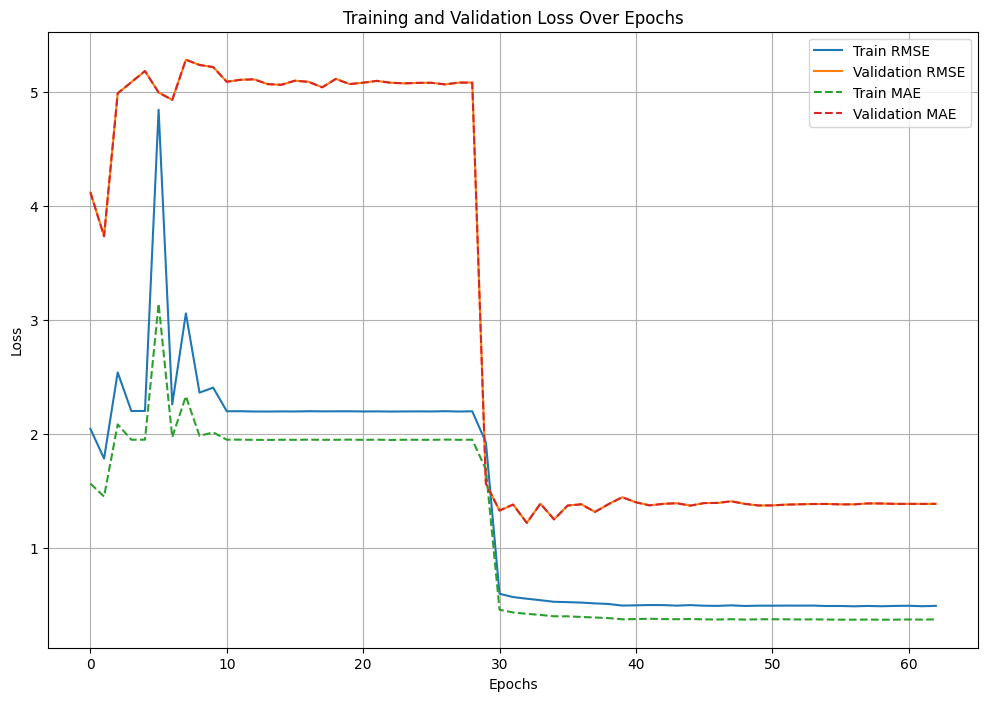

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(train_rmse_losses, label="Train RMSE")
plt.plot(val_rmse_losses, label="Validation RMSE")
plt.plot(train_mae_losses, label="Train MAE", linestyle="--")
plt.plot(val_mae_losses, label="Validation MAE", linestyle="--")
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

In [19]:
model.load_state_dict(best_model_state)  
model.eval()

with torch.no_grad():
    test_rmse = 0.0
    test_mae = 0.0  
    
    for batch_X, batch_y in test_loader:
        test_predictions = model(batch_X)
        test_rmse += rmse_loss(test_predictions, batch_y).item()
        test_mae += mae_loss(test_predictions, batch_y).item()  

    test_rmse /= len(test_loader)
    test_mae /= len(test_loader)

    print(f"Test Loss (RMSE): {test_rmse:.4f}")
    print(f"Test Loss (MAE): {test_mae:.4f}")

Test Loss (RMSE): 1.5629
Test Loss (MAE): 1.5046
